# Validate on Larger Molecules
We ran a series of sugar molecules that have between 10 and XX heavy atoms with Emin, 
and will use this to: 
- Test whether Emin is accurate for larger molecules
- Verify that only testing against PubChem is a good decision
- [TBD] Quantify the runtime as a function of stoichiometry and setting choice

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from emin.source import get_inchi_keys_from_pubchem
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import re

## Load Runs
Get the data across many runs of Emin

In [2]:
run_paths = list(Path('../runs/').glob('*/energies.csv'))
print(f'Found {len(run_paths)} runs')

Found 8 runs


In [3]:
def load_run(path: Path) -> pd.DataFrame:
    """Load the results from a compute_emin run
    
    Args:
        path: Path to the energies.csv file
    Returns:
        Dataframe describing the run
    """
    
    # Load the full dataset
    data = pd.read_csv(path)
    if 'xyz' in data.columns:
        data.drop(columns=['xyz'], inplace=True)
        
    
    # Add the formula and whether each molecule is in pubchem
    formula = path.parent.name
    data['formula'] = formula
    
    pubchem_keys = get_inchi_keys_from_pubchem(formula)
    data['in_pubchem'] = data['inchi_key'].apply(pubchem_keys.__contains__)
    
    # Get the heavy atom count
    heavy_count = sum(map(int, re.findall(r'(?:[A-GI-Z]|[A-Z][a-z])(\d+)', formula)))
    data['heavy_count'] = heavy_count
    
    return data

In [4]:
data = pd.concat([load_run(p) for p in tqdm(run_paths)], ignore_index=True).query('heavy_count > 9')
print(f'Loaded {len(data)} energy evaluations for {len(data["inchi_key"].value_counts())} molecules larger than 9 heavy atoms')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:18<00:00,  2.29s/it]


Loaded 2064981 energy evaluations for 2064443 molecules larger than 9 heavy atoms


## Compute E_min for these larger molecules
At each level of fidelity available using all tested molecules

In [5]:
level_names = ['formula', 'level', 'relax']
data['emin'] = None
for _, group in data.groupby(level_names):
    emin = (group['energy'] - group['energy'].min()).values
    data.loc[group.index, 'emin'] = emin

Compare only for xTB with relaxation

In [6]:
xtb_relax = data.query('level == "xtb" and relax')
print(f'Pulled {len(xtb_relax)} molecules at the target level')

Pulled 711043 molecules at the target level


In [7]:
in_pc = xtb_relax['in_pubchem'].sum()
print(f'{in_pc} are in PubChem')

6853 are in PubChem


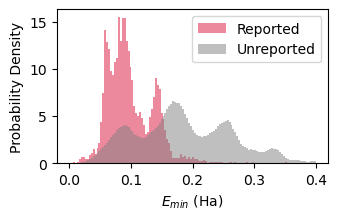

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

all_reported = xtb_relax.query('in_pubchem')
all_unreported = xtb_relax.query('not in_pubchem')

bins = np.linspace(0, 0.4, 128)
ax.hist(all_reported['emin'], bins=bins, color='crimson', label='Reported',density=True,alpha=0.5)
ax.hist(all_unreported['emin'], bins=bins, color='gray', label='Unreported',density=True,alpha=0.5)
ax.legend()

ax.set_xlabel(r'$E_{min}$ (Ha)')
ax.set_ylabel('Probability Density')

plt.savefig('figures/emin_dist-large-molecules.png', dpi=320)

We see the same "molecules over 200 mHa are rarely reported" trend

## Verify Only Searching PubChem is a Good Idea
We can drastically speed up Emin by only computing the energies of molecules in PubChem to find the lowest-energy conformer

In [9]:
level_names = ['formula', 'level', 'relax']
data['emin'] = None
for _, group in data.groupby(level_names):
    emin = (group['energy'] - group.query('in_pubchem')['energy'].min()).values
    data.loc[group.index, 'emin-pc'] = emin

Repeat the plot without PubChem

In [10]:
xtb_relax = data.query('level == "xtb" and relax')
print(f'Pulled {len(xtb_relax)} molecules at the target level')

Pulled 711043 molecules at the target level


Text(0, 0.5, 'Probability Density')

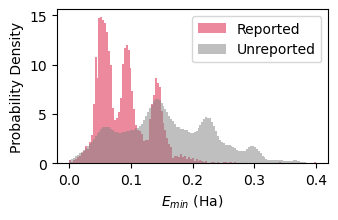

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

all_reported = xtb_relax.query('in_pubchem')
all_unreported = xtb_relax.query('not in_pubchem')

bins = np.linspace(0, 0.4, 128)
ax.hist(all_reported['emin-pc'], bins=bins, color='crimson', label='Reported',density=True,alpha=0.5)
ax.hist(all_unreported['emin-pc'], bins=bins, color='gray', label='Unreported',density=True,alpha=0.5)
ax.legend()

ax.set_xlabel(r'$E_{min}$ (Ha)')
ax.set_ylabel('Probability Density')

There's not a qualitative difference.